In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [37]:
# this command will download the LFW_people's dataset to hard disk.
# lfw_people = fetch_lfw_people(data_home='D:\Senior II\Image Processing\Project\LFW Dataset',
lfw_people = fetch_lfw_people(data_home='D:\Work\CCE\Year 4 - Senior 2\Semester 1\Senior-2-Semester-1\Image Processing\Project',
min_faces_per_person = 70, resize = 0.4)

In [38]:
images = lfw_people.images
print('Images shape:',images.shape)

total_images, h, w = images.shape
print(f'Each image has size: {h} x {w}')

print(70* '-')

m = int(total_images * 0.8)
print('M = Number of examples = ', m)

m_test = total_images - m
print('M_test = Number of test examples = ', m_test)

train_images = images[:int(m)]
print('Train images shape:', train_images.shape)

test_images = images[int(m):]
print('Test images shape:', test_images.shape)

n_features = h*w
print(f'N^2 = n_features = h x w = {n_features}')

print(70* '-')

y = lfw_people.target
print('y has shape:', y.shape)

y_train = y[:int(m)]
print('y_train has shape:', y_train.shape)

y_test = y[int(m):]
print('y_test has shape:', y_test.shape)

target_names = lfw_people.target_names
num_people = target_names.shape[0]
print('Number of people =', num_people)

Images shape: (1288, 50, 37)
Each image has size: 50 x 37
----------------------------------------------------------------------
M = Number of examples =  1030
M_test = Number of test examples =  258
Train images shape: (1030, 50, 37)
Test images shape: (258, 50, 37)
N^2 = n_features = h x w = 1850
----------------------------------------------------------------------
y has shape: (1288,)
y_train has shape: (1030,)
y_test has shape: (258,)
Number of people = 7


In [39]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [40]:
#----------------------- CREATE PEOPLE DICTIONARY -----------------------#

# Key: person ID
# Value: List of all person images indices
person_image_dict = dict()
for image_index in range(m):
    if (y_train[image_index] not in person_image_dict.keys()):
        person_image_dict[y_train[image_index]] = [image_index]
    else:
        person_image_dict[y_train[image_index]].append(image_index)

Gerhard Schroeder


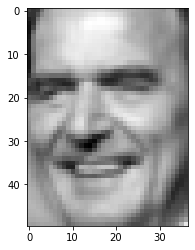

In [41]:
# ------------------ VIEW RANDOM IMAGE ------------------ #
index = int(random.random() * m)
image = images[index,:,:]
name = target_names[y[index]]

print(name)
plt.imshow(image, cmap='gray')
plt.show()

In [42]:
# --------------------- GET FLATTEN IMAGES --------------------- #

# Flatten images array
# Each column is an image

# N^2 * M
flattened_images = train_images.reshape(m, -1).T

# N^2 * M_test
flattened_test_images = test_images.reshape(m_test, -1).T

print(f'Shape of training images after flattening: {flattened_images.shape}')
print(f'Shape of test images after flattening: {flattened_test_images.shape}')

Shape of training images after flattening: (1850, 1030)
Shape of test images after flattening: (1850, 258)


Average image has shape: (1850, 1)


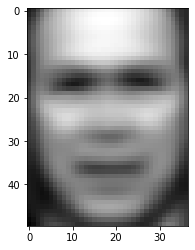

In [68]:
# ----------------- CALCULATE AVERAGE IMAGE ----------------- #

# In all corresponding pixels in all images, we calculate the average

# N^2 * 1
average_image = np.mean(flattened_images, axis = 1)[:,np.newaxis]

print(f'Average image has shape: {average_image.shape}')
plt.imshow(average_image.reshape(h,w), cmap='gray')
plt.show()

In [69]:
#-------------------------------- GET DIFFERENCE IMAGES --------------------------------#

# Subtract the average image from all images
# This is done to remove the average face from all images
# N^2 * M
difference_images = flattened_images - average_image

print(f'Shape after subtracting average face: {difference_images.shape}')


Shape after subtracting average face: (1850, 1030)


Colin Powell


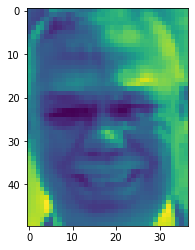

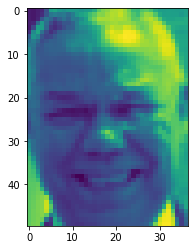

In [70]:
# --------------------- SHOW ONE DIFFERENCE IMAGE AND COMPARE TO ORIGINAL --------------------- #
index = int(random.random() * m)
name = target_names[y_train[index]]

print(name)
plt.imshow(difference_images[:,index].reshape(h, w))
plt.show()

# Print original image
plt.imshow(images[index,:,:])
plt.show()

In [71]:
#--------------------- GET COVARIANCE MATRIX --------------------- #

# C = A * A^T where A = difference_images

A = difference_images

# N^2 * N^2
covariance_matrix = np.matmul(difference_images, difference_images.T)

print('Shape of covariance matrix:', covariance_matrix.shape)

Shape of covariance matrix: (1850, 1850)


In [72]:
# --------------------------------- GET EIGENVALUES AND EIGENVECTORS --------------------------------- #

# Calculate the eigenvalues and eigenvectors of L
# where L = A^T * A

# M * M
L = np.matmul(A.T, A)

print('Shape of L:', L.shape)

# M eigenvalues and M eigenvectors
# where M is the number of examples

eigenvalues, eigenvectors = np.linalg.eig(L)
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of eigenvectors:', eigenvectors.shape)


Shape of L: (1030, 1030)
Shape of eigenvalues: (1030,)
Shape of eigenvectors: (1030, 1030)


In [73]:
# ------------------------ GET EIGENFACES ------------------------ #


# Those Eigenvectors determine linear combinations of the M training set face images 
# to form the eigenfaces U

# difference_images: N^2 * M
# difference_images[:, i, np.newaxis]: N^2 * 1

# eigenvectors: M * M
# eigenvectors[:, i, np.newaxis]: M * 1

# N^2 * M
eigenfaces = np.zeros((n_features, m))

# TODO optimize the for loop
for i in range(m):
    eigenfaces += np.matmul(difference_images[:, i, np.newaxis], eigenvectors[:, i, np.newaxis].T)

print('Shape of eigenfaces:', eigenfaces.shape)


Shape of eigenfaces: (1850, 1030)


George W Bush


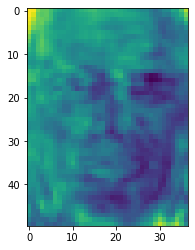

In [74]:
# ------------------------ SHOW A RANDOM EIGENFACE ------------------------ #

index = int(random.random() * m)
name = target_names[y_train[index]]

print(name)
plt.imshow(eigenfaces[:,index].reshape(h, w))
plt.show()


In [693]:
# For each person, get one image from flattened_images
# Calculate the weigths w
omegas = np.zeros((num_people, m))

for person in range(num_people):
    
    #get 10 image of the person
    image = np.zeros((n_features, 1))
    
    # for i in range(10):
    #     image_index = person_image_dict[person][i]
    #     image += flattened_images[:, image_index, np.newaxis]
    # image /= 10

    # averaged_eigenfaces = np.zeros((n_features,1))
    # for i in person_image_dict[person]:
    #     averaged_eigenfaces += eigenfaces[:, i, np.newaxis]
    # averaged_eigenfaces /= len(person_image_dict[person])


    image_index = person_image_dict[person][0]
    image = flattened_images[:, image_index, np.newaxis]

    
    # calculate the weights
    for i in range(m):
        omegas[person, i] += np.matmul(eigenfaces[:, i, np.newaxis].T , image - flattened_average_image)


In [695]:
omegas = np.zeros((num_people, m))

for i in range(m):
    # Calculate the weigths w
    #get image i
    image = flattened_images[:,i, np.newaxis]
    w = np.zeros((m,))
    for j in range(m):
        w[j] = np.matmul(eigenfaces[:,j, np.newaxis].T, image - flattened_average_image)
    omegas[y_train[i], :] += w

for i in range(num_people):
    omegas[i] /= len(person_image_dict[i])

## Testing

In [696]:
# Accuracy calculation
count = 0
trials = 1000
for trial in range(trials):
    # New test image
    index = int(random.random() * m_test)
    #take on image from A randomly
    test_image = flattened_test_images[:,index, np.newaxis]

    # Calculate the weigths w
    w = np.zeros((m,))
    for i in range(m):
        w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T, test_image - flattened_average_image)

    min_distance = float('inf')
    nearest_person = -1

    for person in range(num_people):
        distance = np.linalg.norm(w - omegas[person,:])
        if(distance < min_distance):
            min_distance = distance
            nearest_person = person

    threshold = float('inf')
    if (min_distance < threshold):
        if(nearest_person == y_train[index]):
            count += 1
print(f'Accuracy: {count/trials*100}%')

ValueError: operands could not be broadcast together with shapes (1030,) (7,) 

In [ ]:
# New test image
# index = int(random.random() * images.shape[0])
index = 506
#take on image from A randomly
test_image = flattened_images[:,index, np.newaxis]
print(f'Test image has shape: {test_image.shape}')

Test image has shape: (1850, 1)


In [ ]:
# Calculate the weigths w
w = np.zeros((m,))
for i in range(m):
    w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T, test_image - flattened_average_image)

In [ ]:
min_distance = float('inf')
nearest_person = -1

for image_index in range(m):
    distance = np.linalg.norm(w - omegas[:, image_index])
    if(distance < min_distance):
        min_distance = distance
        nearest_person = y[image_index]
    # print(f'Distance between test image and {target_names[person]} is {distance}')

threshold = float('inf')
if (min_distance < threshold):
    print(f'The nearest person is {target_names[nearest_person]}')
    print(f'True person: {target_names[y[index]]}')
else:
    print('No person found')

The nearest person is Donald Rumsfeld
True person: Donald Rumsfeld


In [ ]:
# # Calculate the distance between the test image and the image of the person
# # The person with the smallest distance is the person in the test image

# min_distance = float('inf')
# nearest_person = -1

# for person in range(num_people):
#     distance = np.linalg.norm(w - omegas[person, :])
#     if(distance < min_distance):
#         min_distance = distance
#         nearest_person = person
#     print(f'Distance between test image and {target_names[person]} is {distance}')

# threshold = float('inf')
# if (min_distance < threshold):
#     print(f'The nearest person is {target_names[nearest_person]}')
#     print(f'True person: {target_names[y[index]]}')
# else:
#     print('No person found')
